## Objective - Rank universities based on different features

#### Import modules and prepare dataset.

In [12]:
# Import sklearn tools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from scipy import interpolate
%matplotlib inline

# Load dataset
dataset = pd.read_csv('shanghai_data.csv')

# Check which columns have null values.
for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print(f"% of missing data in '{col}' - {pct_missing*100:.2f}%")

# Fill the data.
dataset.fillna(dataset.mean(), inplace=True)

# Checking for duplicates. NOTE: world_rank will become the target.
print('Duplication in dataset: {}'.format(dataset.duplicated(subset=['world_rank']).any()))    # -> True

# NOTE: There are duplicates in the dataset because the rankings change every year, so the rankings are updated.

# Split data into target and data variables.
data_df = dataset.loc[:, 'total_score':'pcp']

# Encoding target colum.
target_df = dataset.loc[:, 'world_rank']

data = data_df.to_numpy()
target = target_df.to_numpy()

print('data.shape: {}'.format(data.shape))
print('target.shape: {}'.format(target.shape))

# University names (for reference).
university_names = dataset.loc[:, 'university_name'].to_numpy()

print(f'target.dtype: {target.dtype}')    # -> object

# NOTE: The reason why the above code returns object is bc the data is string,
#       but the strings must be the same length, so it is stored in this dtype.

# Get indexes where the targets can be converted to floats.
indexes = []

for index in range(len(target)):
    if '-' not in target[index]:
        indexes.append(index)

print('target (after sample selection): {}'.format(target := target[indexes].astype(float)))

print('target.shape (after sample selection): {}'.format(target.shape))
print('data.shape (after sample selection): {}'.format((data := data[indexes]).shape))

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(data, target)

# Scale the data.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

# NOTE: If you would like to see what the features stand for visit: 
#       https://www.kaggle.com/mylesoneill/world-university-rankings?select=shanghaiData.csv

% of missing data in 'world_rank' - 0.00%
% of missing data in 'university_name' - 0.02%
% of missing data in 'national_rank' - 0.02%
% of missing data in 'total_score' - 77.52%
% of missing data in 'alumni' - 0.02%
% of missing data in 'award' - 0.04%
% of missing data in 'hici' - 0.04%
% of missing data in 'ns' - 0.45%
% of missing data in 'pub' - 0.04%
% of missing data in 'pcp' - 0.04%
% of missing data in 'year' - 0.00%
Duplication in dataset: True
data.shape: (4897, 7)
target.shape: (4897,)
target.dtype: object
target (after sample selection): [  1.   2.   3. ...  98.  99. 100.]
target.shape (after sample selection): (1102,)
data.shape (after sample selection): (1102, 7)
X_train.shape: (826, 7)
y_train.shape: (826,)
X_test.shape: (276, 7)
y_test.shape: (276,)


#### Data analysis

% of zeros in data -> 0.0388903292714545
% of nonzeros in data -> 0.9611096707285455


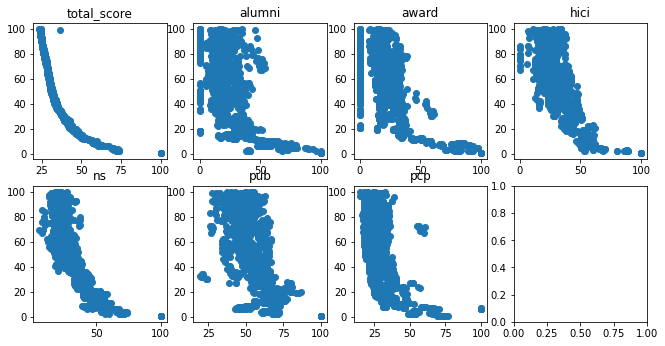

In [13]:
# Check if there are a significant amount of zeros in the data.
print(f'% of zeros in data -> {np.sum(data == 0)/data.size}')
print(f'% of nonzeros in data -> {np.sum(data != 0)/data.size}')

# Check how each feature is correlated to the target.
fig, axs = plt.subplots(2, 4, figsize=(11, 5.5))
features = ['total_score', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp']

axs = [ax for ax in axs.ravel()]

# Scatter the data.
for i in range(7):
    axs[i].scatter(data[:, i], target)
    axs[i].set_title(features[i])

# NOTE: total_score seems like the most correlated feature.
# NOTE: It seems as if all of the features do not have a linear relationship towards the target variable.
#       This means that a polynomial regression model would be preferred over a linear one.

#### Apple models to the data

In [15]:
# Create linear model.
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

poly_reg = LinearRegression()

# Edit the data to make features polynomial.
quadratic = PolynomialFeatures()
X_train_poly = quadratic.fit_transform(X_train)
X_test_poly = quadratic.transform(X_test)

# Fit the model on the transformed data.
poly_reg.fit(X_train_poly, y_train);


# NOTE: the ';' suppresses the output of the jupyter cell.

#### Plot the results of the algorithm

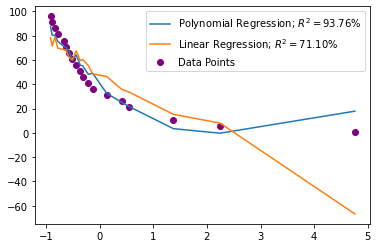

In [38]:
# Get the R2 scores of the algorithms.
poly_score = r2_score(y_test, poly_reg.predict(X_test_poly))*100
lin_score = r2_score(y_test, lin_reg.predict(X_test))*100

indexes = []

# Select random samples.
for i in range(1, 101, 5):
    try:
        index = np.where(y_test == i)[0][0]
    except IndexError:
        index = np.where(y_test  == i + 1)[0][0]
    else:
        indexes.append(index)

samples_target = y_test[indexes]
samples = X_test[indexes]

# Store predictions.
samples_pred = {
    'poly': poly_reg.predict(quadratic.transform(samples)),
    'lin': lin_reg.predict(samples)
}

# Scatter data and see how predictions differ.
plt.scatter(
    samples[:, 0], 
    samples_target, 
    label=f'Data Points', color='purple')

# Plot poly_reg predictions.
plt.plot(
    samples[:, 0],
    samples_pred['poly'],
    label=f'Polynomial Regression; $R^2 = {poly_score:.2f}$%')

# Plot lin_reg predictions.
plt.plot(
    samples[:, 0],
    samples_pred['lin'],
    label=f'Linear Regression; $R^2 = {lin_score:.2f}$%')

plt.legend(loc='best')

#### Select 5 random schools and show different predictions

In [39]:
# Create indexes variable that holds a set(). This is to avoid redundancy.
indexes = set()

for i in range(5):
    indexes.add(choice(range(len(X_test))))

for index in indexes:
    print(f'\n----- {university_names[index]} -----')
    print(f'\tPolynomial Regression Prediction: {poly_reg.predict(X_test_poly[index].reshape(1, -1))[0]:.2f}')
    print(f'\tLinear Regression Prediction: {lin_reg.predict(X_test[index].reshape(1, -1))[0]:.2f}')
    print(f'\tTarget: {y_test[index]}')


----- Lund University -----
	Polynomial Regression Prediction: 42.84
	Linear Regression Prediction: 53.69
	Target: 38.0

----- University of Cape Town -----
	Polynomial Regression Prediction: 73.28
	Linear Regression Prediction: 68.59
	Target: 74.0

----- The University of Texas Southwestern Medical Center at Dallas -----
	Polynomial Regression Prediction: 25.25
	Linear Regression Prediction: 35.92
	Target: 26.0

----- University of Guelph -----
	Polynomial Regression Prediction: 10.81
	Linear Regression Prediction: 32.56
	Target: 22.0

----- Rutgers, The State University of New Jersey - New Brunswick -----
	Polynomial Regression Prediction: 32.46
	Linear Regression Prediction: 46.38
	Target: 31.0
